In [2]:
# Import of the necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
## Accuracy
from sklearn.metrics import mean_squared_error
## Building Model
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import statsmodels.api as sm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
## Data Visualization
import matplotlib.pyplot as plt
## Multidimensional Scaling
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# metabolom data
## description: 
contains measurements of monoterpenes in certain plant leaves in AUC/mg. These data come from the 2021 paper 'Unifying community detection across scales from genomes to landscapes' from Hudon and coworkers.

Columns:
- SampleID
- Species: there are wyoming, 3-tip, hybrid
- Other: AUC/mg data
    
**Research question**: Can we classify different species by the AUC/mg that we have?

**Method**: PCA

**Rationale for using the method**: this analysis will make use of PCA. The data consists of 17 variables. The dimension is too high to analyze. With PCA we can reduce the dimension and visualize the data. 

**Expectations**: I expect that PCA is able to reduce the dimensions. In addition, I believe we can see clusters of species. Species with the same 'characteristics' will form groups. Once this behavior is observed, research can look further into the clusters to design experiments.

In [2]:
df = pd.read_csv("metabolom_data.csv")
df.head()

SampleID  Species     Unk3.2     Unk3.6   Unk11.9   Unk12.4    aPinene  \
0    MF032  wyoming  17.447216  78.480388  2.575015  0.480588   6.873549   
1    MF034  wyoming   0.000000   0.000000  0.566885  9.274434  29.331204   
2    MF036  wyoming  13.247976  52.978520  3.838784  0.000000   5.958195   
3    MF038  wyoming   0.000000  71.897745  5.582314  7.300492   8.662203   
4    MF049  wyoming  15.501606  56.658287  7.009434  0.397118   0.000000   

     Camphene    bPinene  aPhellendrine   pcymene     Cineole    Unk18.2  \
0   14.667799  10.505447      64.308777  5.311575    6.917810  10.258485   
1  189.922801  20.664100       0.368826  8.201353  140.641077   0.000000   
2    6.564323  23.170531      61.671574  2.010833    4.594991   9.309720   
3    3.662696   9.404492       0.165965  1.854227    6.792163   9.031663   
4    9.505731  11.259664      18.164837  3.222653   17.167722   9.857530   

     Unk18.6    Unk20.5    Camphor       Unk21     Unk21.5    Unk23.5  
0  29.725402   5.320274  92.868922   32.733879  245.373027   9.190845  
1   1.275490   0.000000   0.000000  675.617594   13.323675   0.646352  
2  27.877841  10.200175  54.894681   25.178064  232.263740   8.166170  
3  32.740878   7.444111  67.025993   24.894070  392.559512  10.195839  
4   6.071136  10.047028  87.913989   33.114384    0.341623  11.994086

In [3]:
df.tail()

SampleID  Species     Unk3.2      Unk3.6    Unk11.9   Unk12.4    aPinene  \
89    MF307  wyoming  34.999561  110.826808   3.713417  1.092522   3.635173   
90    MF308    3-tip  13.748601    0.000000   0.000000  8.024367  47.490551   
91    MF309    3-tip  13.946355    0.000000   0.000000  8.285327  81.580728   
92    MF310  wyoming  43.199183   67.388458  17.454482  0.788624   2.435465   
93    MF311  wyoming  29.156576   21.561263   1.397200  0.840508   1.580013   

      Camphene    bPinene  aPhellendrine    pcymene    Cineole   Unk18.2  \
89   25.416764  11.319855      57.996107   9.337529  31.488208  8.461742   
90  125.726955  20.436416       0.000000  30.094909   4.942429  0.000000   
91  142.999149   0.670380       0.000000  38.130357   4.841986  0.000000   
92   17.218276  74.732220      18.961495   3.335756  47.823441  6.603522   
93    8.091641  26.992020      20.915596   2.582817  30.153951  2.312392   

      Unk18.6    Unk20.5    Camphor       Unk21     Unk21.5   Unk23.5  
89  18.543212   3.612682  91.353085   19.635540  193.448965  7.282802  
90   0.759998   0.000000   0.000000  421.669616   12.199856  0.544602  
91   0.000000   0.000000   0.000000  497.831436   13.430400  0.000000  
92  10.623682  41.042015  49.214527   31.067011   75.488476  0.203115  
93  17.001017   7.083195  14.525973    8.187077   45.853621  2.287864

After loading the data, we see a column 'SampleID'. It does not represent anything in this dataset, so I'll remove it.

In [4]:
df = df.drop("SampleID",axis=1)

Check the missing value before going deeper into the df.

In [5]:
df.isna().sum()

Species          0
Unk3.2           0
Unk3.6           0
Unk11.9          0
Unk12.4          0
aPinene          0
Camphene         0
bPinene          0
aPhellendrine    0
pcymene          0
Cineole          0
Unk18.2          0
Unk18.6          0
Unk20.5          0
Camphor          0
Unk21            0
Unk21.5          0
Unk23.5          0
dtype: int64

In [6]:
df.Species.unique()

array(['wyoming', '3-tip', 'hybrid'], dtype=object)

In [7]:
df.loc[(df.Species == 'wyoming'),'Species'] = 1
df.loc[(df.Species == '3-tip'),'Species'] = 2
df.loc[(df.Species == 'hybrid'),'Species'] = 3
Y = df.Species

We check the dependent value. After that, we change it to a number to make it easier for further steps.

In [8]:
X = df.iloc[:,1:]
X.var(axis = 0).min(), X.var(axis=0).max()

(12.886749063417717, 73000.89092252743)

We set the other variable as independent values.

**Treatment of data**:

PCA requires the data to be centered. If the data does not have consistent variance across columns, we need to divide by the standard deviation. 

For this, we can code it by ourselves. However, there is a package from sklearn. Using the StandardScaler from sklearn will make our code tidy.

In [9]:
X = StandardScaler().fit_transform(X)

The data is standardized now. We want to use PCA, find the eigenvalues and plot them in a scree plot.

The scree plot can help us to find the component that we should use. We will initialize the PCA with 10 components. We can put every value for the components. After that, we will check when will we get a value higher than 80%.

In [10]:
n = 10
pca = PCA(n_components=n)
pca.fit(X)

PCA(n_components=10)

Let's plot the explained variance ratio. This ratio shows how much variation each component explains. 

As we can see, the first, second, and third components explain most variance. The fourth and later components do not contribute that much.

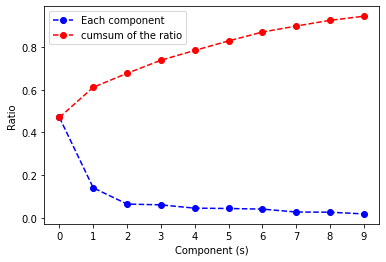

(array([5, 6, 7, 8, 9]),)


In [11]:
plt.plot(pca.explained_variance_ratio_,"ob--",label="Each component")
plt.plot(np.cumsum(pca.explained_variance_ratio_),"or--",label="cumsum of the ratio")
plt.xticks([*range(0, n, 1)])
plt.ylabel("Ratio")
plt.xlabel("Component (s)")
plt.legend()
plt.show()
print(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8))

The scree plot also confirms that there is a drop in contribution after the third component. I would like to pick **3** components.

However, it cannot explain more than 80% of the variance. So, I pick 6 components because it is higher than 80%.

In [12]:
n = 6
pca = PCA(n_components=n)
components = pca.fit_transform(X)
labels = [f'Component {i}' for i in range(1, n+1)]
component_df = pd.DataFrame(data=components, columns=labels)
component_df.head()

Component 1  Component 2  Component 3  Component 4  Component 5  \
0    -3.019580    -2.823399     0.670234    -0.069715     0.865268   
1     3.499776     0.690652    -0.779688    -2.011836     1.802956   
2    -2.667033    -2.683478    -0.027861     0.091728     1.058165   
3    -1.647201    -2.941417     0.438928    -0.410229     2.450521   
4    -1.517476    -0.067614     0.625473    -0.815752     0.043904   

   Component 6  
0    -0.904632  
1    -0.025706  
2    -0.800270  
3    -1.070381  
4     1.799867

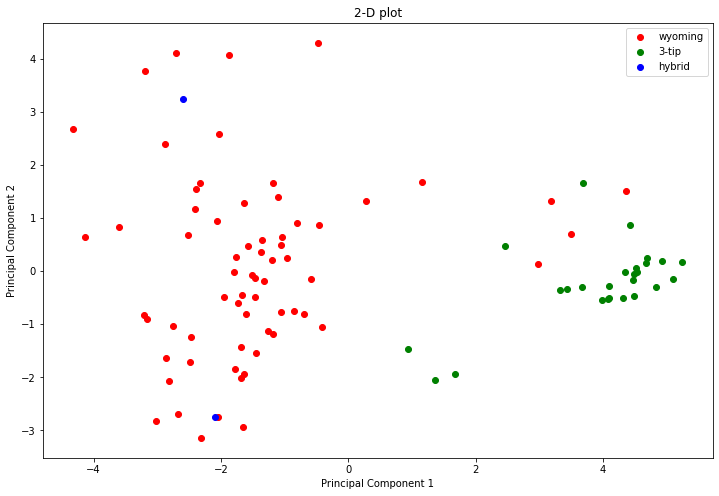

In [13]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2-D plot')
for c, i, target_name in zip("rgb", [1, 2, 3], ["wyoming","3-tip","hybrid"]):
    plt.scatter(components[Y == i, 0], components[Y == i, 1], c=c, label=target_name,cmap="rainbow")
ax.legend()

I want to make a biplot, but it needs too much code. So, I try another package and also add a label for the species.

**Try another package to plot it better**

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [17] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


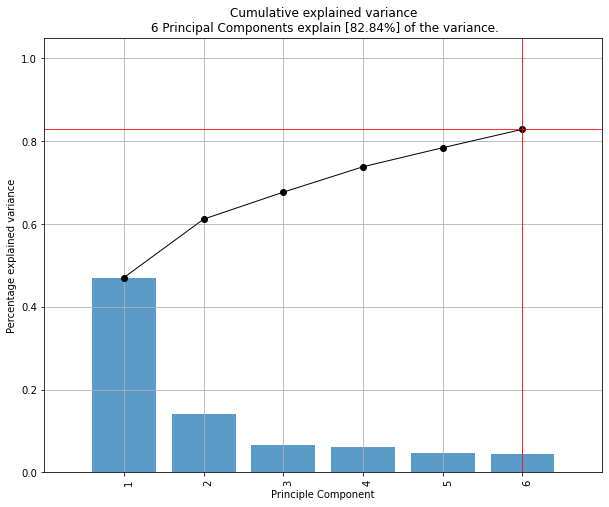

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 6 Principal Components explain [82.84%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [14]:
from pca import pca
df = pd.read_csv("metabolom_data.csv")
X=df.drop(["SampleID","Species"],axis=1)
Y=df.Species
model = pca(n_components=6,normalize=True)
results = model.fit_transform(X)
model.plot(figsize=(10,8))

According to the above visualization, 6 components seem to be able to explain about 83% of the dataset. Whereas the 1st principal component explains almost 45%. 

To get a little bit more insight, a biplot will be generated next step to view the features that most influence the dataset.

[pca] >Plot PC1 vs PC2 with loadings.


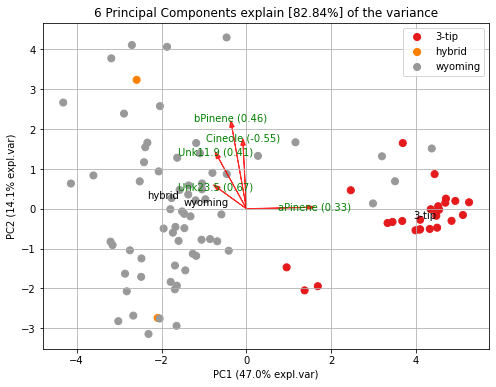

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'6 Principal Components explain [82.84%] of the variance'}, xlabel='PC1 (47.0% expl.var)', ylabel='PC2 (14.1% expl.var)'>)

In [15]:
model.biplot(n_feat=5, legend=True, figsize=(8,6), y=df.Species, label=True)

**Interpretation and reflection**

The first PC explains 47.0% and the second PC 14.1%. There seems to be a very clear distinction of species according to the colored markings as the 'Species' feature which denotes whether the species are 3-tip, hybrid, or wyoming.

aPinene	seems less correlated to other features. Other features have the same direction suggesting at least some correlation.

### Conclusion
From the available results, it is most likely that aPinene is less correlated with other features in 5 features. Other features correlate with each other. 

I think PCA groups 3-tips and wyoming quite well. However, we do not have much data for hybrid. So, we cannot make sure the method is not suitable for this species. Maybe we can try a different method.

Let's try LDA to check the performance.


**Try another method to cluster it**
 
**Method**: LDA

https://www.knowledgehut.com/blog/data-science/linear-discriminant-analysis-for-machine-learning



**Rationale for using the method**: this analysis will make use of LDA. The data consists of 17 variables.

The dimension is too high to analyze. With LDA we can reduce the dimension and visualize the data.

As the website mentioned, we want to classify the specific, we can give it a try.



**Expectations**: I expect that LDA can reduce the dimensions. In addition, I believe we can see clusters of species. 

Species with the same 'characteristics' will form groups. Once this behavior is observed, research can look further into the clusters to design experiments.

In [16]:
df = pd.read_csv("metabolom_data.csv")
y = df.Species
X = df.drop(["SampleID","Species"],axis=1)

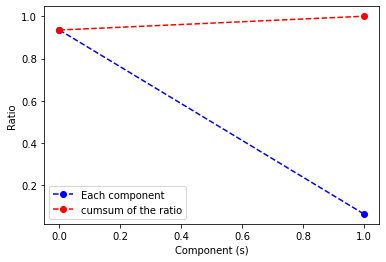

In [17]:
model = LinearDiscriminantAnalysis(n_components=2).fit(X, y)
plt.plot(model.explained_variance_ratio_,"ob--",label="Each component")
plt.plot(np.cumsum(model.explained_variance_ratio_),"or--",label="cumsum of the ratio")
plt.ylabel("Ratio")
plt.xlabel("Component (s)")
plt.legend()
plt.show()

As the plot show, we can get more than 90 % by the first component. I think it is nice. Let's keep working on it to classify the species.

Text(0.5, 1.0, 'LDA for classification species')

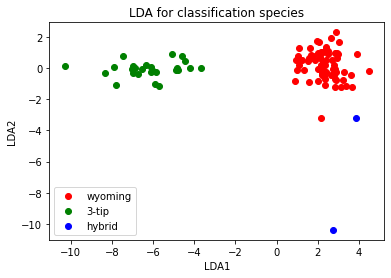

In [18]:
X_LDA = model.transform(X)
df.loc[(df.Species == 'wyoming'),'Species'] = 1
df.loc[(df.Species == '3-tip'),'Species'] = 2
df.loc[(df.Species == 'hybrid'),'Species'] = 3
for c, i, target_name in zip("rgb", [1, 2, 3], ["wyoming","3-tip","hybrid"]):
    plt.scatter(X_LDA[y == i, 0], X_LDA[y == i, 1], c=c, label=target_name,cmap="rainbow")
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.legend()
plt.title("LDA for classification species")

**Interpretation and reflection**

The first LDA explains 93.5% and the second LDA 6.5%. I think it performs better than PCA.

### Conclusion
PCA focuses on principal components and maximizes the variance in the given data. 

However, LDA maximizes the separation between different classes.


I would say LDA performs better on multi-class classification tasks than PCA. In this dataset, we must use LDA instead of PCA to get a better result.

# SourceData2
## description
contains infrared spectra from saliva from people that tested negative and people that tested positive for SARS nCoV2019. For each subject, three spectra were determined. The data accompany the study 'Infrared based saliva screening test for COVID-19' from Wood et al. 

Columns:
- ID
- Ct: the Ct value for each patient.
- other: infrared spectra data

As the Ct value represents the cycle number at which the signal breaches the threshold for positivity, a lower Ct value is indicative of a higher viral load.

Reference:
Rupert Waudby-West, Benjamin J. Parcell, Colin N.A. Palmer, Samira Bell, James D. Chalmers, Moneeza K. Siddiqui
The association between SARS-CoV-2 RT-PCR cycle threshold and mortality in a community cohort.
European Respiratory Journal 2021 58: 2100360; DOI: 10.1183/13993003.00360-2021
https://erj.ersjournals.com/content/58/1/2100360

**Research question**: Can we use the infrared spectra from saliva to predict the Ct-value?

**Method**: Linear Regression

**Rationale for using the method**: the reason for using the method is being able to predict the Ct value of a patient, given the saliva infrared spectra data. I want to estimate the relationship between the dependent variable (Ct value) and the independent variables (saliva infrared spectra data). The method also gives insight into what variables are more important, although, the problem of multicollinearity should also take into account.

**Expectations**: I expect there to be a relationship between the Ct value, and saliva data. This is because the viral load will affect the Ct value. I believe if patients with more viral in their bodies, it will also impact the saliva data.

**Assumption**:
- there are no measurement errors.

In [19]:
df = pd.read_excel("SourceData2.xlsx")
df.head()

ID  Ct      1300      1298      1296      1294      1292      1290  \
0  N1 NaN  0.277705  0.277532  0.277387  0.277217  0.277042  0.276930   
1  N1 NaN  0.251624  0.251438  0.251268  0.251067  0.250843  0.250645   
2  N1 NaN  0.083310  0.083293  0.083307  0.083338  0.083391  0.083478   
3  N2 NaN  0.067509  0.067070  0.066684  0.066359  0.066106  0.065938   
4  N2 NaN  0.129576  0.128690  0.127912  0.127232  0.126676  0.126306   

       1288      1286  ...       818       816       814       812       810  \
0  0.276856  0.276737  ...  0.242726  0.241897  0.241107  0.240374  0.239742   
1  0.250467  0.250280  ...  0.213427  0.212628  0.211891  0.211234  0.210662   
2  0.083585  0.083674  ...  0.085724  0.085260  0.084823  0.084445  0.084137   
3  0.065852  0.065828  ...  0.055012  0.054969  0.054902  0.054832  0.054781   
4  0.126138  0.126113  ...  0.099128  0.098794  0.098337  0.097886  0.097527   

        808       806       804       802       800  
0  0.239234  0.238833  0.238523  0.238314  0.238197  
1  0.210173  0.209763  0.209450  0.209267  0.209202  
2  0.083894  0.083715  0.083602  0.083543  0.083495  
3  0.054767  0.054787  0.054823  0.054857  0.054893  
4  0.097272  0.097091  0.096970  0.096906  0.096881  

[5 rows x 253 columns]

In [20]:
df.tail()

ID     Ct      1300      1298      1296      1294      1292      1290  \
178  P30  16.95  0.169349  0.169277  0.169212  0.169121  0.169057  0.169072   
179  P30  16.95  0.277632  0.277423  0.277119  0.276688  0.276211  0.275814   
180  P31  32.10  0.175842  0.174590  0.173493  0.172534  0.171712  0.171067   
181  P31  32.10  0.305833  0.304135  0.302663  0.301395  0.300495  0.300195   
182  P31  32.10  0.271944  0.270299  0.268843  0.267598  0.266660  0.266113   

         1288      1286  ...       818       816       814       812  \
178  0.169133  0.169197  ...  0.103987  0.103974  0.103963  0.103903   
179  0.275529  0.275318  ...  0.177726  0.178111  0.178484  0.178827   
180  0.170605  0.170303  ...  0.097160  0.097295  0.097339  0.097355   
181  0.300463  0.301050  ...  0.221463  0.222138  0.222542  0.222775   
182  0.265897  0.265881  ...  0.173923  0.174306  0.174538  0.174685   

          810       808       806       804       802       800  
178  0.103825  0.103762  0.103700  0.103615  0.103513  0.103393  
179  0.179161  0.179454  0.179650  0.179756  0.179837  0.179928  
180  0.097408  0.097484  0.097523  0.097521  0.097521  0.097536  
181  0.222966  0.223190  0.223473  0.223837  0.224288  0.224766  
182  0.174833  0.175021  0.175224  0.175406  0.175568  0.175727  

[5 rows x 253 columns]

After loading the data, we see a column 'ID'. It does not represent anything in this dataset, so I'll remove it.

In [21]:
df = df.drop(["ID"],axis=1)

Check the missing value before going deeper into the df.

In [22]:
print(df.isna().sum())
print(df.isna().sum().sum())

Ct      132
1300      0
1298      0
1296      0
1294      0
       ... 
808       0
806       0
804       0
802       0
800       0
Length: 252, dtype: int64
132


We can see there is some missing value. Moreover, it only appears in Ct. Normally how handling the missing value is a common problem for data scientists. 

If I drop out of the missing value, I will lose more than half of the data. However, we do not know why it is missing. Is it detecting values too low? 

If this is the case, what is the threshold for it? We do not know it. So, I will drop it out to prevent bias.

Although I can interpolate it, I do not think interpolating is a nice approach. 

We want to know the relationship between saliva and Ct. If we interpolate saliva data that will affect our result because the missing is more than half of the dataset.

In [23]:
df = df.dropna()

We want to predict the Ct values by saliva data. So, Ct values will be the dependent variable. Saliva data will be independent variables.

In [24]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [25]:
X.var(axis = 0).min(), X.var(axis=0).max()

(0.02055185104793071, 0.06359047528429683)

I think the max and min of the variance are pretty close. So, I do not need to normalize it.

Multilinear regression is a technique used to estimate the relationship between two or more independent variables (in this case saliva data) and one dependent variable (Ct value)

In [26]:
model = linear_model.LinearRegression()
model.fit(X, Y)
pred = model.predict(X)

Text(0.5, 1.0, 'CT value predict by saliva infrared spectra data (MLR)')

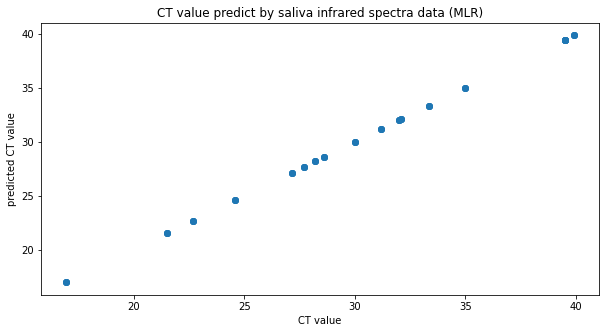

In [27]:
plt.figure(figsize=(10, 5))
plt.scatter(Y,pred)
plt.ylabel('predicted CT value')
plt.xlabel('CT value')
plt.title("CT value predict by saliva infrared spectra data (MLR)")

In [28]:
print(mean_squared_error(Y, pred))
print(model.score(X, Y))

1.0732830402566162e-23
1.0


The score is 1. I think it will be better to check by other method.

In [29]:
# Gets additional information about the model
X = sm.add_constant(X) # adding a constant
olsmod = sm.OLS(Y, X).fit()
print(olsmod.summary())

                            OLS Regression Results                            
Dep. Variable:                     Ct   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 07 Jul 2022   Prob (F-statistic):                nan
Time:                        15:31:17   Log-Likelihood:                 1248.3
No. Observations:                  51   AIC:                            -2395.
Df Residuals:                       0   BIC:                            -2296.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.5604        inf          0        n

The model mention about strong multicollinearity. That's try PLSR to fix this problem.

**Try another method to predict it**

I think MLR can fit it very nicely. However, there is a problem with multicollinearity. Let's try another method to fix it. I think PCR or PLSR will be better for this dataset.
 
**Method**: PLSR

https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html

**Rationale for using the method**: I can use PCR or PLSR for this regression model. However, I think we already know the Ct value(label). So, it is supervised learning. I think PLSR is better than PCR for supervised learning.

**Expectations**: I expect that PLSR can reduce the dimensions. In addition, I believe we can see predict the Ct value. Once this model is observed, we can use saliva to detect the Ct value.

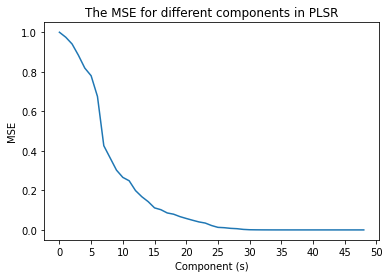

In [30]:
component = []
for i in range(1,50):
    pls = PLSRegression(n_components=i)
    pls.fit(X, Y)
    pred = pls.predict(X)
    component.append(mean_squared_error(Y, pred))
plt.xlabel("Component (s)")
plt.ylabel("MSE")
plt.title("The MSE for different components in PLSR")
plt.locator_params('x', nbins=20)
plt.plot(component/component[0])

I rescale it to get the MSE on a percentage scale. I think 25 is pretty well. It has less MSE. Let's choose 25 as the components and do further steps.

In [31]:
pls = PLSRegression(n_components=25)
pls.fit(X, Y)
pred = pls.predict(X)

Text(0.5, 1.0, 'CT value predict by saliva infrared spectra data (PSLR)')

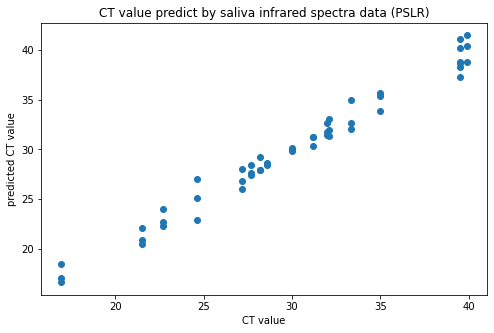

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(Y,pred)
plt.ylabel('predicted CT value')
plt.xlabel('CT value')
plt.title("CT value predict by saliva infrared spectra data (PSLR)")

In [33]:
print(mean_squared_error(Y, pred))
print(pls.score(X,Y))

0.8596310733867691
0.9781296226582604


**Interpretation and reflection**

I perform MLR and PSLR. For MLR I get R-square 1 and PLSR is not good as MLR. I only get 0.98 for PSLR.

Although MLR can have a better prediction, PLSR can use less to get a similar result. No matter which method I use, it shows a very nice R-square.

### Conclusion
I use different to check the result. No matter which method I choose, it performs very well. 

So, I would say there is a strong relationship between Ct value and saliva data. 

I believe we can use saliva data to predict Ct value in the future. That means we can detect the viral loading not only by detecting from the nose but also from saliva.

# randompoisson
## description
contains 1000 by 10000 Poisson distributed random numbers with means per column taken from an exponential distribution. This can be considered simplified fictive/dummy count data, e.g., from genomics/transcriptomics, with 1000 observations in 10000 variables.
    
**Research question**: Is PCA a nice model when we have to handle the random number?

**Method**: PCA

**Rationale for using the method**: 
For unsupervised learning, normally we will try PCA to get the result. Moreover, in high dimensions, we have to reduce the dimension.

**Expectations**: 
I expect PCA can help us find some clusters from the dataset.

In [34]:
df = pd.read_table('randompoisson.dat.gz',compression="gzip",sep=" ",header=None)
df

0     1     2     3     4     5     6     7     8     9     ...  9990  \
0     572   752   666   140  2211   398    23  2071  1653   708  ...  2865   
1     588   750   620   166  2265   402    23  2152  1580   744  ...  2792   
2     580   694   666   166  2148   348    31  2141  1509   699  ...  2763   
3     600   773   681   132  2264   351    22  2146  1685   713  ...  2813   
4     576   751   645   121  2292   368    23  2050  1577   689  ...  2734   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
995   598   750   652   130  2243   373    22  2137  1651   743  ...  2885   
996   599   786   642   163  2251   398    23  2166  1631   663  ...  2828   
997   585   752   663   155  2178   372    27  2118  1610   732  ...  2769   
998   565   798   667   129  2253   374    18  2131  1568   736  ...  2910   
999   555   716   637   152  2292   357    20  2139  1521   706  ...  2832   

     9991  9992  9993  9994  9995  9996  9997  9998  9999  
0     410   293    86   999   199    80   359   483   367  
1     467   316    97   994   179    96   370   472   388  
2     459   272   121   914   199    88   400   476   420  
3     415   321    98   985   184   105   376   488   387  
4     426   325   100  1015   166   102   398   437   414  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
995   419   298    79   979   183   104   403   475   400  
996   422   323    94   992   176   107   378   495   405  
997   435   322    87   916   169   104   398   444   382  
998   446   308   118   926   187   101   404   493   389  
999   438   352   102  1007   192    84   402   461   371  

[1000 rows x 10000 columns]

In [35]:
df.head()

0     1     2     3     4     5     6     7     8     9     ...  9990  \
0   572   752   666   140  2211   398    23  2071  1653   708  ...  2865   
1   588   750   620   166  2265   402    23  2152  1580   744  ...  2792   
2   580   694   666   166  2148   348    31  2141  1509   699  ...  2763   
3   600   773   681   132  2264   351    22  2146  1685   713  ...  2813   
4   576   751   645   121  2292   368    23  2050  1577   689  ...  2734   

   9991  9992  9993  9994  9995  9996  9997  9998  9999  
0   410   293    86   999   199    80   359   483   367  
1   467   316    97   994   179    96   370   472   388  
2   459   272   121   914   199    88   400   476   420  
3   415   321    98   985   184   105   376   488   387  
4   426   325   100  1015   166   102   398   437   414  

[5 rows x 10000 columns]

In [36]:
df.tail()

0     1     2     3     4     5     6     7     8     9     ...  9990  \
995   598   750   652   130  2243   373    22  2137  1651   743  ...  2885   
996   599   786   642   163  2251   398    23  2166  1631   663  ...  2828   
997   585   752   663   155  2178   372    27  2118  1610   732  ...  2769   
998   565   798   667   129  2253   374    18  2131  1568   736  ...  2910   
999   555   716   637   152  2292   357    20  2139  1521   706  ...  2832   

     9991  9992  9993  9994  9995  9996  9997  9998  9999  
995   419   298    79   979   183   104   403   475   400  
996   422   323    94   992   176   107   378   495   405  
997   435   322    87   916   169   104   398   444   382  
998   446   308   118   926   187   101   404   493   389  
999   438   352   102  1007   192    84   402   461   371  

[5 rows x 10000 columns]

In [37]:
df.isna().sum().sum()

0

Loading the dataset and also check the missing values.

In [38]:
X = StandardScaler().fit_transform(df)

To centralize and normalize befor performing PCA, Standardscaler is a nice choice before further steps.

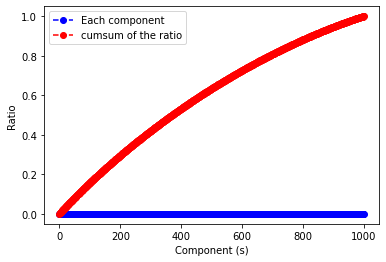

In [39]:
n = 1000
pca = PCA(n_components=n)
pca.fit(X)
plt.plot(pca.explained_variance_ratio_,"ob--",label="Each component")
plt.plot(np.cumsum(pca.explained_variance_ratio_),"or--",label="cumsum of the ratio")
plt.ylabel("Ratio")
plt.xlabel("Component (s)")
plt.legend()
plt.show()

We can get an 80% ratio at around 700 components. Let's try different packages for the further steps.

**Try another package before working further**

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [10000] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[700]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


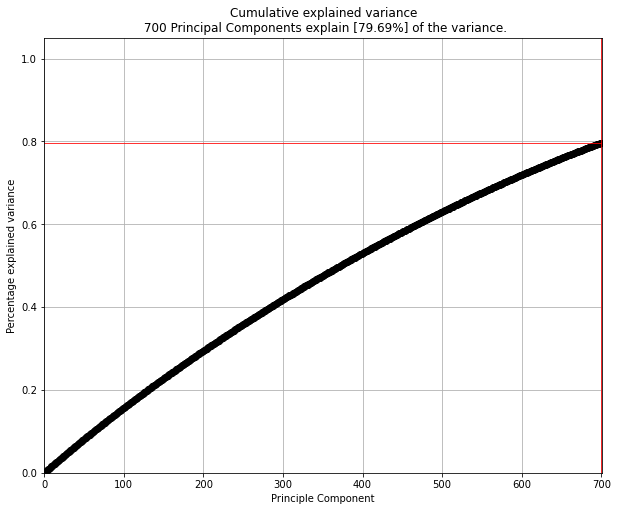

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 700 Principal Components explain [79.69%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [40]:
from pca import pca
model = pca(n_components=700,normalize=False)
results = model.fit_transform(X)
model.plot(figsize=(10,8))

[pca] >Plot PC1 vs PC2 with loadings.


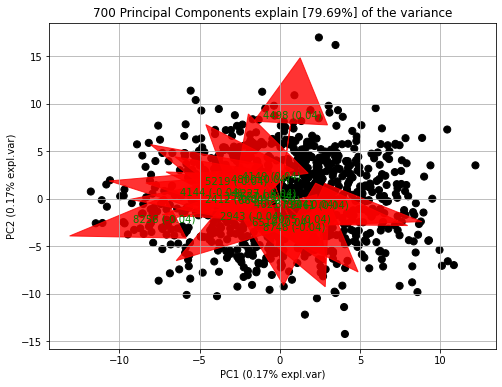

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'700 Principal Components explain [79.69%] of the variance'}, xlabel='PC1 (0.17% expl.var)', ylabel='PC2 (0.17% expl.var)'>)

In [41]:
model.biplot(n_feat=18, legend=False, figsize=(8,6), label=True)

In [42]:
df.describe()

0            1            2            3            4     \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    598.690000   758.301000   661.557000   144.737000  2235.213000   
std      24.267402    27.628024    24.357505    12.434728    50.076694   
min     526.000000   667.000000   592.000000   106.000000  2062.000000   
25%     582.750000   739.000000   644.000000   136.000000  2202.000000   
50%     599.000000   758.000000   661.500000   145.000000  2235.000000   
75%     616.000000   776.000000   678.000000   153.000000  2269.000000   
max     667.000000   836.000000   734.000000   179.000000  2394.000000   

              5            6            7            8            9     ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean    368.953000    24.327000  2115.199000  1603.550000   712.842000  ...   
std      18.614599     4.807617    46.222223    39.424812    26.297311  ...   
min     306.000000    11.000000  1957.000000  1472.000000   625.000000  ...   
25%     357.000000    21.000000  2085.000000  1576.750000   694.000000  ...   
50%     370.000000    24.000000  2118.000000  1604.000000   712.000000  ...   
75%     380.000000    28.000000  2144.000000  1629.000000   731.000000  ...   
max     435.000000    41.000000  2240.000000  1736.000000   798.000000  ...   

              9990         9991         9992         9993         9994  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean   2835.339000   423.142000   319.591000    97.148000   981.502000   
std      54.234947    21.013172    18.499512     9.863234    30.983253   
min    2662.000000   342.000000   259.000000    70.000000   867.000000   
25%    2797.000000   408.750000   307.000000    91.000000   960.000000   
50%    2835.000000   423.000000   321.000000    97.000000   982.000000   
75%    2870.000000   436.000000   331.000000   104.000000  1001.000000   
max    3004.000000   494.000000   388.000000   129.000000  1086.000000   

             9995         9996         9997         9998         9999  
count  1000.00000  1000.000000  1000.000000  1000.000000  1000.000000  
mean    180.15500   102.616000   385.592000   482.154000   391.565000  
std      13.30007     9.598994    19.798725    22.079397    19.544149  
min     139.00000    77.000000   321.000000   401.000000   331.000000  
25%     172.00000    96.000000   372.000000   468.000000   378.000000  
50%     180.00000   103.000000   385.000000   482.000000   391.000000  
75%     189.00000   109.000000   400.000000   497.000000   405.000000  
max     219.00000   135.000000   445.000000   556.000000   452.000000  

[8 rows x 10000 columns]

**Interpretation and reflection**

As we can see, PCA cannot separate it nicely. PCA is not the best one for this dataset. Each component can only explain a little. We can see the std is similar. That's the reason PCA cannot do it well.

### Conclusion
I perform PCA and find it is not a good method for this dataset. PCA might be useful for the random dataset. 

However, before using it, we must check the variance. If the variance is not big enough, it cannot separate the sample nicely.

# lysozyme_rmsds
## description
contains a distance matrix of a selection of lysozyme structures from the Protein DataBank (PDB). Lysozyme is one of the most used/studied proteins, with >5400 structures available in the database. Distances were determined as root-mean-square deviation (RMSD) after least-squares alignment using the CE align algorithm.


Columns:
- distance matrix between different lysozyme.

**Research question**: 

Can we find the relationship between different lysozyme?

**Method**: MDS

https://www.statisticshowto.com/multidimensional-scaling/

**Rationale for using the method**: 
Multidimensional scaling is an algorithm that transforms a dataset into another one with a lower dimension. Moreover, it keeps the same distances between points and reasonably preserves patterns and clusters.
As we can see the dataset also show the relationship between each lysozyme. 

**Expectations**: 
I expect I can get a clear separation between each group of lysozyme.

In [43]:
df = pd.read_csv("lysozyme_rmsds.csv",header=0,index_col=0)
df.head()

1ta0      5m1y       1flq      4ru1       1uia      3ma8  \
1ta0   0.000000  9.944671  10.914137  5.368414  10.147917  6.330169   
5m1y   9.944671  0.000000   0.351689  8.778090   0.360542  6.532751   
1flq  10.914137  0.351689   0.000000  8.781974   0.201154  5.892352   
4ru1   5.368414  8.778090   8.781974  0.000000   8.802099  6.510888   
1uia  10.147917  0.360542   0.201154  8.802099   0.000000  8.169978   

           2zc6       4m53       1cwv      6nup  ...       5dla      4u2a  \
1ta0  13.397298   4.796260   6.708178  5.249331  ...  10.748649  4.697932   
5m1y   6.447437  11.661980  10.892651  8.494948  ...   0.450633  6.518186   
1flq   6.476417  10.141856   8.676370  8.771998  ...   0.300225  6.862653   
4ru1  11.596014   6.613473   6.483236  7.988591  ...  10.002309  9.219876   
1uia   6.458828  11.358191  10.635841  8.761022  ...   0.296834  7.002353   

           6fe3       4ws6      225l      1l17       4zee       5hmj  \
1ta0   6.442754   5.967243  6.613105  6.550033  10.885024  10.758552   
5m1y  10.142028   8.008221  5.411168  5.225135   0.423226   0.382607   
1flq   8.398187   8.305965  5.385658  5.390587   0.312325   0.241490   
4ru1   8.978669   5.131378  8.586637  9.308215   7.545538   9.995192   
1uia  11.221244  10.178038  5.404494  5.409590   0.333920   0.247616   

           4qdn       4x6p  
1ta0  10.531178   7.134530  
5m1y   4.660109   6.716681  
1flq   4.646545   6.584307  
4ru1  11.135262  10.210994  
1uia   4.522474   6.734468  

[5 rows x 172 columns]

In [44]:
df.tail()

1ta0      5m1y      1flq       4ru1      1uia       3ma8      2zc6  \
1l17   6.550033  5.225135  5.390587   9.308215  5.409590  12.250709  6.513305   
4zee  10.885024  0.423226  0.312325   7.545538  0.333920   5.877982  6.964976   
5hmj  10.758552  0.382607  0.241490   9.995192  0.247616   5.882972  6.930295   
4qdn  10.531178  4.660109  4.646545  11.135262  4.522474  10.147237  5.835574   
4x6p   7.134530  6.716681  6.584307  10.210994  6.734468   9.490398  6.749283   

           4m53      1cwv      6nup  ...      5dla      4u2a      6fe3  \
1l17   9.136604  9.281223  5.937270  ...  5.382979  7.049519  9.732915   
4zee  10.116202  8.698651  8.497236  ...  0.286652  6.996474  7.530556   
5hmj  10.138183  8.662763  8.145623  ...  0.146255  6.440816  8.419391   
4qdn  12.161131  9.798632  9.081107  ...  4.654700  6.477708  5.306617   
4x6p   5.397088  6.086818  8.703318  ...  6.762921  6.667636  6.015851   

           4ws6       225l       1l17      4zee      5hmj      4qdn       4x6p  
1l17   7.471374   0.162718   0.000000  5.373169  5.411511  5.635189  11.884937  
4zee  10.148434   5.368462   5.373169  0.000000  0.273322  4.552373   6.720388  
5hmj  10.177090   5.406244   5.411511  0.273322  0.000000  4.656623   6.772748  
4qdn   6.123214   5.641388   5.635189  4.552373  4.656623  0.000000   5.874020  
4x6p   7.194302  11.930525  11.884937  6.720388  6.772748  5.874020   0.000000  

[5 rows x 172 columns]

In [45]:
df.isna().sum().sum()

0

There is no missing value in the dataset. 
For the next step, we don’t want to give more weight to some features only because their order of magnitude is higher than others’. A simple 0–1 normalization will solve this problem effectively.

In [46]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(df)

In [47]:
dist_manhattan = manhattan_distances(x_scaled)
dist_euclid = euclidean_distances(x_scaled)

Manhattan distance is usually preferred over the more common Euclidean distance when there is high dimensionality in the data. Hamming distance is used to measure the distance between categorical variables, and the Cosine distance metric is mainly used to find the amount of similarity between two data points.

There are several distance methods. I think manhattan and euclidean are suitable for this dataset. 
Before putting components we must check how many components should we put. Let's check it in a different distance method!

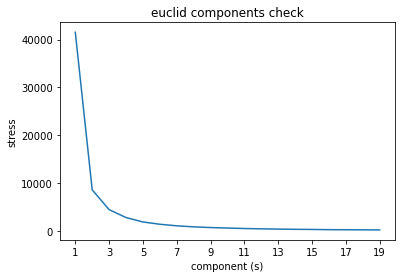

In [48]:
stress = []
max_range = 20
for dim in range(1, max_range):
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)
    mds.fit_transform(dist_euclid)
    stress.append(mds.stress_) 
plt.plot(range(1, max_range), stress)
plt.xticks(range(1, max_range, 2))
plt.xlabel('component (s)')
plt.ylabel('stress')
plt.title("euclid components check")
plt.show()


In [49]:
stress = []
max_range = 20
for dim in range(1, max_range):
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)
    mds.fit_transform(dist_manhattan)
    stress.append(mds.stress_)
plt.plot(range(1, max_range), stress)
plt.xticks(range(1, max_range, 2))
plt.xlabel('component (s)')
plt.ylabel('stress')
plt.title("manhattan components check")
plt.show()

In the graph, we can see that 2 components can perform well. I will try 2 components for the further steps.

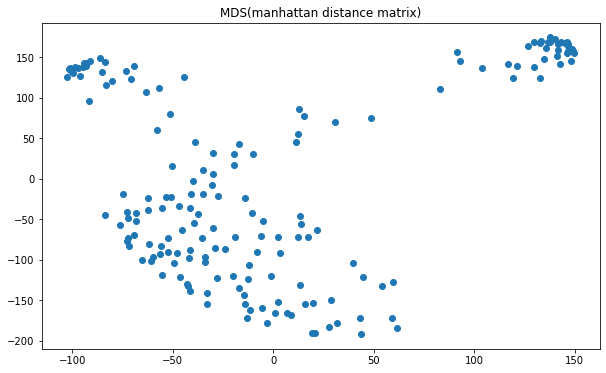

In [ ]:
mds_sklearn = MDS(n_components=2)
x_sklearn = mds_sklearn.fit_transform(dist_manhattan)
plt.figure(figsize=(10,6))
plt.scatter(x_sklearn[:,0],x_sklearn[:,1])
plt.title('MDS(manhattan distance matrix)')
plt.show()

As we can see from the result, middle-upper, middle right, and middle, there are some lysozyme structures close to each other. That means they have a similar structure. Maybe scientists can take the closely related lysozyme to do some research. In the future, they can do some research about the evolution of the lysozyme. The closer the lysozyme is, the function closer it will be.

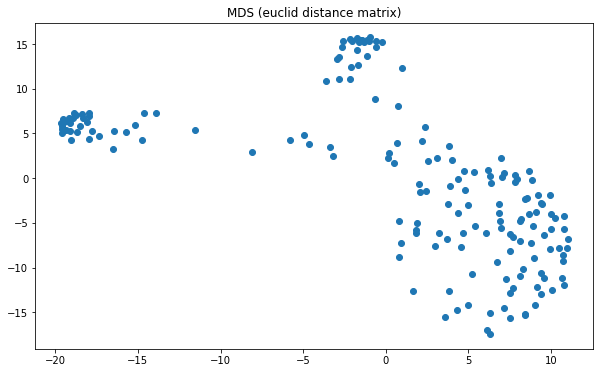

In [ ]:
mds_sklearn = MDS(n_components=2)
x_sklearn = mds_sklearn.fit_transform(dist_euclid)
plt.figure(figsize=(10,6))
plt.scatter(x_sklearn[:,0],x_sklearn[:,1])
plt.title('MDS (euclid distance matrix)')
plt.show()

As we can see from the result, middle-bottom, bottom-right, and upper-left, there are some lysozyme structures close to each other. That means they have a similar structure. I think this one performs better. It groups them into three clusters. I think maybe we can try the unsupervised method - PCA for checking the performance.

**Try another Method**

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed on the [172] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[30]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


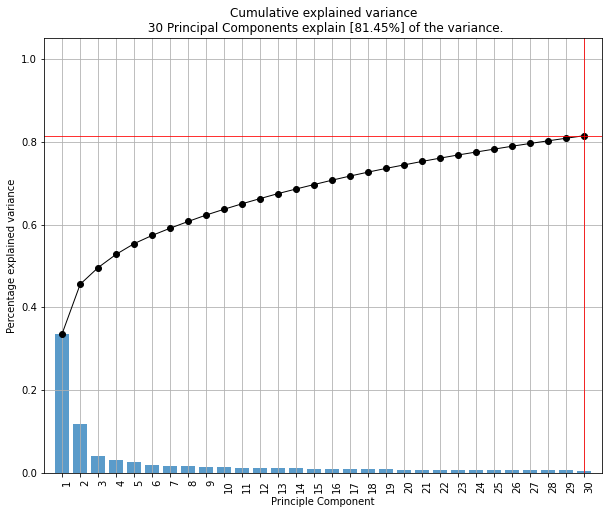

(<Figure size 720x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 30 Principal Components explain [81.45%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 432x288 with 0 Axes>

In [ ]:
df = pd.read_csv("lysozyme_rmsds.csv",header=0,index_col=0)
model = pca(n_components=30,normalize=True)
results = model.fit_transform(df)
model.plot(figsize=(10,8))

[pca] >Plot PC1 vs PC2 with loadings.


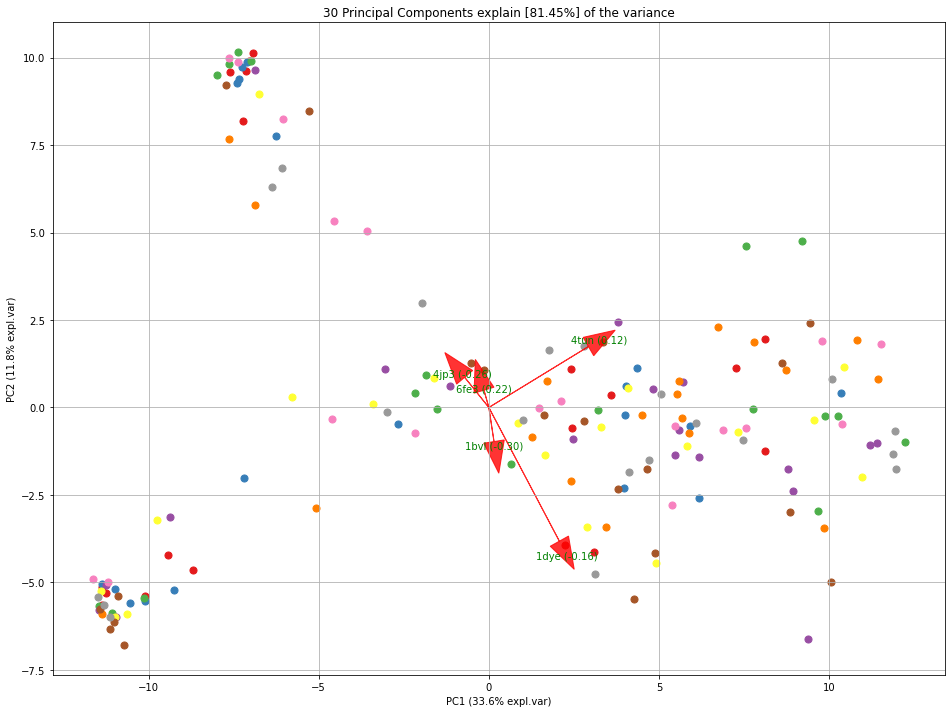

(<Figure size 1152x864 with 1 Axes>,
 <AxesSubplot:title={'center':'30 Principal Components explain [81.45%] of the variance'}, xlabel='PC1 (33.6% expl.var)', ylabel='PC2 (11.8% expl.var)'>)

In [ ]:
model.biplot(n_feat=5, legend=False, figsize=(16,12), label=False)

**Interpretation and reflection**

The first PC explains 33.6% and the second PC 11.8%. There is no clear cluster of the lysozyme by using PCA. To perform by MDS get a better cluster result.

### Conclusion

From the output of PCA and MDS, we can find MDS performs better no matter in manhattan or in euclid. 

In the future, if scientists want to do some research about lysozome, they must choose the close one. 

The ungroup lysosome should add more samples to find the relationship between each other.